## NLP & Binary Classification: Toxic Comment Classification Challenge
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

** Dataset Information: **

- a large number of Wikipedia comments which have been labeled by human raters for toxic behavior 

** Attribute Information:**

- id	
- comment_text
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate                

** Objective of this project **

- Identify and classify toxic online comments


# Data

In [0]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [9]:
# Load Data
filepath = 'drive/app/toxic/'
df = pd.read_csv(filepath+'train.csv')
pd.set_option('display.max_colwidth', -1)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


# Data Preprocessing

#### Spilt Train Test sets

In [0]:
X = df['comment_text']
y = df['toxic'].values

seed = 101
np.random.seed(seed)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(127656,) (31915,) (127656,) (31915,)


#### Tokenize text

In [42]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
print('Found %s unique tokens.' % len(tokenizer.word_index))

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Found 183444 unique tokens.


In [43]:
len(X_train)
#X_train[:10]
#tokenizer.word_counts
#tokenizer.word_index

127656

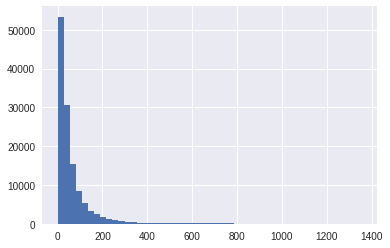

In [44]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins = 50)
plt.show()

In [45]:
maxlen = 200
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print(X_train.shape,X_test.shape)
#X_train[np.argmax(totalNumWords)]

(127656, 200) (31915, 200)


# 1. Baseline Model: 

In [0]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout,LSTM,Bidirectional,Conv1D,MaxPooling1D
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,classification_report
from keras.callbacks import ModelCheckpoint,EarlyStopping

batch_size = 128
epochs = 25
file_path = filepath+'weights_best_model.hdf5'

In [0]:
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [0]:
def model_train(model):
    # callbacks
    early_stop = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='max') 
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, early_stop]
    # train the model
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size,
                          verbose=2, callbacks=callbacks_list)
    # plot train history
    plot_model_history(model_history)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def model_evaluate():
    # predict class with test set
    y_pred_test =  model.predict_classes(X_test, batch_size=batch_size, verbose=0)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(y_test,y_pred_test)*100))
    print('roc auc:\t{:0.3f}'.format(roc_auc_score(y_test,y_pred_test)))

    #classification report
    print('\n')
    print(classification_report(y_test, y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(y_test, y_pred_test)

    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 32)           9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
__________

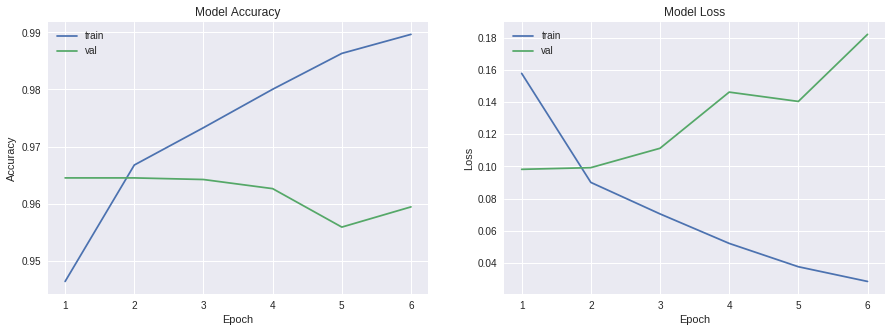

In [51]:
# train the model
max_features = 20000
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

Accuracy:	96.4%
roc auc:	0.854


             precision    recall  f1-score   support

          0       0.97      0.99      0.98     28856
          1       0.89      0.72      0.79      3059

avg / total       0.96      0.96      0.96     31915



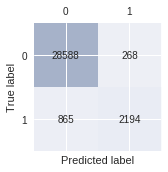

In [60]:
# evaluate model with test set
model_evaluate()

# 2. GloVe.6B.50d

In [0]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features=20000):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return max_features, embedding_matrix

In [0]:
def get_model(max_features, embed_dim, embedding_matrix):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],
                       weights=[embedding_matrix]))#,trainable=Fa
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 50)           1000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 32)           4832      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)          

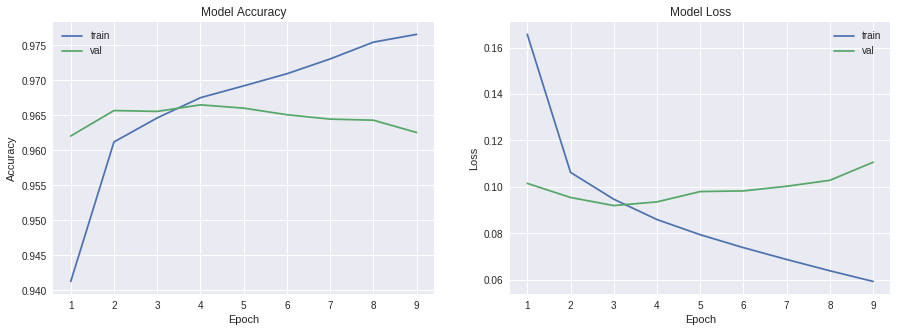

In [65]:
# embedding matrix
EMBEDDING_FILE = filepath+'glove.6B/glove.6B.50d.txt'
embed_dim = 50 #word vector dim
max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)

# train the model
model = get_model(max_features, embed_dim, embedding_matrix)
model_train(model)

Accuracy:	96.3%
roc auc:	0.888


             precision    recall  f1-score   support

          0       0.98      0.98      0.98     28856
          1       0.81      0.80      0.80      3059

avg / total       0.96      0.96      0.96     31915



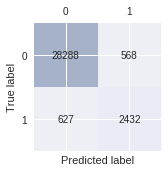

In [66]:
# evaluate model with test set
model_evaluate()

# 3. GloVe.6B.100d

Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 32)           9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)          

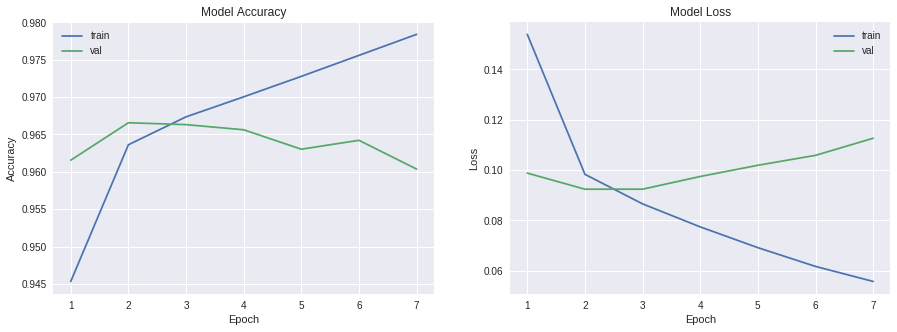

In [63]:
# embedding matrix
EMBEDDING_FILE = filepath+'glove.6B/glove.6B.100d.txt'
embed_dim = 100 #word vector dim
max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)

# train the model
model = get_model(max_features, embed_dim, embedding_matrix)
model_train(model)

Accuracy:	96.0%
roc auc:	0.895


             precision    recall  f1-score   support

          0       0.98      0.98      0.98     28856
          1       0.78      0.81      0.80      3059

avg / total       0.96      0.96      0.96     31915



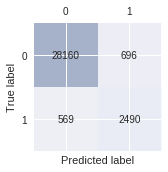

In [64]:
# evaluate model with test set
model_evaluate()